# CVR Registret

This code cleans the Danish register of company information. Specifically, the open lists of companies available here: https://www.sktst.dk/aktuelt/skatteoplysninger-for-selskaber/

In [1]:
import pandas as pd 
import numpy as np 

In [2]:
def percentile(n):
    '''
        Example: df.groupby(year)[var].agg([percentile(10), percentile(90)]).plot()
    '''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = f'P{n:2d}' 
    return percentile_

# Read in data

In [3]:
dd = []
for yr in range(2012, 2019+1): 
    print(yr)
    if yr == 2015: 
        encoding = 'latin'
    else: 
        encoding = 'utf'
        
    d_ = pd.read_csv(f'skatteliste-{yr}.csv', encoding=encoding, na_values='\xa0')
    d_['year'] = yr
    dd.append(d_)

2012


/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2013
2014
2015
2016
2017
2018
2019


Concatenate into a single dataframe

In [4]:
dat = pd.concat(dd)
del dd

In [5]:
dat['dummy_co2'] = dat['Kode = K = Kulbrinte'] == 'K'
del dat['Kode = K = Kulbrinte']

dat['taxed_by_co2'] = dat['Kulbrinte/tonnage'] == 'Kulbrintebeskattet'
dat['taxed_by_tonnage'] = dat['Kulbrinte/tonnage'] == 'Tonnagebeskattet'
del dat['Kulbrinte/tonnage']

In [6]:
del dat['Unnamed: 20']

In [7]:
cols_category = ['Skattepligtsbestemmelse', 'Selskabstype']
for c in cols_category: 
    dat[c] = dat[c].astype('category')

Much of this relates to the `kulbrinteskat` (carbo-hydrates  tax). 

In [8]:
dict_ren = {'Administrationsselskabets CVR-nr.':'parent_cvr', 'Indkomstår':'income_year', 'CVR-nr.':'cvr', 
           'Navn':'name', 'SE-nr.':'se_nr', 'Selskabstype':'company_type', 'Skattepligtic indkomst':'income',
           'Underskud':'deficit', 'Skattepligtig indkomst':'taxable_income', 'Skattepligtsbestemmelse':'taxation_category', 
           'Selskabsskat':'tax', 'Skattepligtig Kulbrinteindkosmt':'taxable_ch_income', 
           'kulbrinte_skat':'ch_tax', 'Underskud fratrukket i selskabsindkomst jf. KB':'deficit_subtracted_from_ch_tax',
           'Selskabsindkomst jf. KB':'tax_cf_ch', 'SE nr. Kulbrinte':'se_nr_ch', 'Selskabsskat af KB':'tax_of_ch', 
           'Kulbrinteskat':'ch_tax', 'Skattepligtig Kulbrinteindkomst':'taxable_ch_income'}
dat.rename(columns=dict_ren, inplace=True)

In [9]:
dat['date_ajour'] = pd.to_datetime(dat['Dato ajour'])
del dat['Dato ajour']

In [10]:
I = dat.parent_cvr == 0.0 # in 2014, all missings are coded as 0.0 for some reason
dat.loc[I, 'parent_cvr'] = np.nan

In [11]:
ch_vars = ['taxable_ch_income', 'ch_tax',
       'Underskud fratrukket i kulbrinteindkomst', 'tax_cf_ch',
       'deficit_subtracted_from_ch_tax', 'tax_of_ch', 'se_nr_ch', 'dummy_co2',
       'taxed_by_co2', 'taxed_by_tonnage']

In [12]:
dat['net_inc']= dat.taxable_income - dat.deficit

I = dat.taxable_income.notnull() & dat.deficit.isnull()
dat.loc[I, 'net_inc'] = dat.loc[I, 'taxable_income']

I = dat.taxable_income.isnull() & dat.deficit.notnull()
if I.any():
    dat.loc[I, 'net_inc'] = -dat.loc[I, 'deficit']
else: 
    print('(none found here)')

(none found here)


### Categorize firms based on the name

We do not observe much about firms, but their names contain (imperfect/imprecise) info about them. 

In [13]:
dat.name = dat.name.str.lower()

In [14]:
dat['dum_as'] = dat.name.str.contains('a/s')
dat['dum_aps'] = dat.name.str.contains('aps')
dat['dum_ivs'] = dat.name.str.contains('ivs')
dat['dum_ab'] = dat.name.str.contains('a/b')
dat['dum_realestate'] = dat.name.str.contains('ejendom')
dat['dum_holding'] = dat.name.str.contains('holding')
dat['dum_invest'] = dat.name.str.contains('invest')
dat['dum_consult'] = dat.name.str.contains('consult')
dat['dum_service'] = dat.name.str.contains('service')
dat['dum_dot_dk'] = dat.name.str.contains('.dk')
dat['dum_doctor'] = dat.name.str.contains('læge')
dat['dum_carpenter'] = dat.name.str.contains('tømrer')
dat['dum_transport'] = dat.name.str.contains('transport') | dat.name.str.contains('lastvogn')
dat['dum_plumbing'] = dat.name.str.contains('vvs') | dat.name.str.contains('kloak')
dat['dum_import'] = dat.name.str.contains('import')
dat['dum_masonry'] = dat.name.str.contains('murer')
dat['dum_nielsen'] = dat.name.str.contains('nielsen')
dat['dum_sorensen'] = dat.name.str.contains('sorensen')

In [15]:
cc = ['autocenter', 'automob', 'automester', 'autoværk', 'autoclean', 'autolak', 'autoophug', 'autoteknik', 'autodele', 'autogården', 'biler']
c = cc[0]
I = dat.name.str.contains(c)
for c in cc[1:]: 
    I = I | dat.name.str.contains(c)
dat['dum_cars'] = I == True

In [16]:
cols_dum = [c for c in dat.columns if c[:4] == 'dum_']

### `dat['cat']`: firm category 
A neat categorical variable

**Warning:** Firms can have multiple dummies switched on: then only the last one is kept. 

In [17]:
dat['cat'] = np.nan
for c in cols_dum[4:]: 
    name = c[4:]
    dat.loc[dat[c], 'cat'] = name
dat['cat'] = dat['cat'].astype('category')

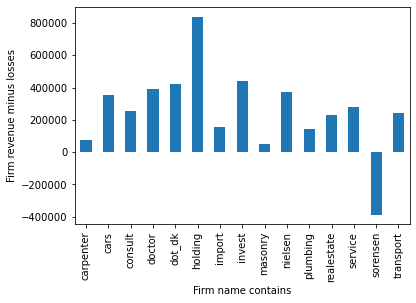

In [18]:
ax = dat.groupby('cat').net_inc.mean().plot(kind='bar'); 
ax.set_ylabel('Firm revenue minus losses'); ax.set_xlabel('Firm name contains'); 

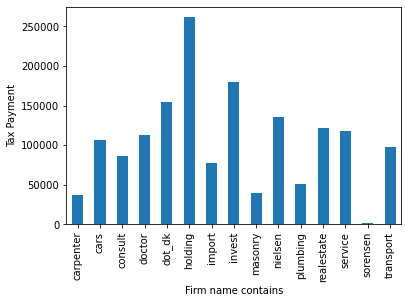

In [19]:
ax = dat.groupby('cat').tax.mean().plot(kind='bar'); 
ax.set_ylabel('Tax Payment'); ax.set_xlabel('Firm name contains'); 

# Export for Students

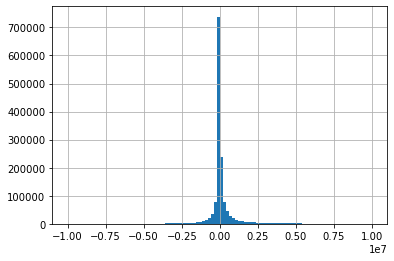

In [20]:
# income makes sense if we delete the very large firms (over 10 mio net earnings before taxes )
I = np.abs(dat.net_inc) < 10_000_000
dat[I].net_inc.hist(bins=100);

## Sample Selection

<AxesSubplot:xlabel='year'>

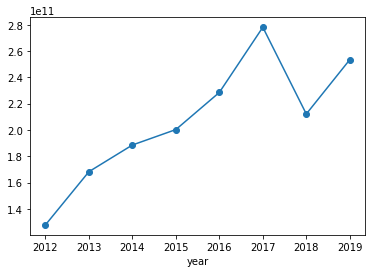

In [21]:
I = (dat.parent_cvr.isnull())
dat[I].groupby('year').net_inc.sum().plot(marker='o')

In [46]:
I = ((dat.company_type == 'Enkeltstående selskab') # no conglomorates 
     & (dat.parent_cvr.isnull()) # not a daughter 
     & (np.abs(dat.net_inc) < 10_000_000)) # net inc before tax below 10 mio DKK 
print(f'Selecting {I.mean():5.2%} of obs. ({I.sum():,d} obs.)')
d = dat[I].sort_values(['cvr', 'year'])

Selecting 47.97% of obs. (1,099,982 obs.)


### Making the sample balanced

In [47]:
tmp = d.groupby(['cvr', 'year']).net_inc.count().groupby(level='cvr').max()
cvr_drop = tmp[tmp == 2].index.values
print(f'Dropping {len(cvr_drop)} CVR numbers')
d = d.loc[d.cvr.isin(cvr_drop) == False, :].copy()

Dropping 18 CVR numbers


In [48]:
d['num_years'] = d.groupby('cvr').net_inc.transform('count')

# select a balanced sample
I = d.num_years == d.year.unique().size
print(f'Selecting {I.mean():5.2%} of obs. ({I.sum():,d} obs.)')
d = d[I].copy()

Selecting 47.23% of obs. (519,416 obs.)


### Add anonymized firm ID variable 

The `CVR` number is too directly related to the firm. Instead, we create `firmid` as `0, 1, ..., N`. 

In [49]:
c_ = d.cvr.drop_duplicates().reset_index(drop=True)
c_.index.name = 'firmid'
d = pd.merge(d, c_.reset_index(), on='cvr', how='left')
del d['cvr']

In [50]:
# make sure the dataset is ready to do first differencing 
d.sort_values(['firmid', 'year'], inplace=True)

### Save dataset

In [51]:
cols = ['firmid', 'year', 'taxable_income', 'deficit', 'tax', 'net_inc', 'cat'] + cols_dum
d_ = d[cols].copy()
for c in cols_dum: 
    d_[c] = d_[c].astype(int)
d_.to_csv('cvr_extract.csv', index=False)

In [52]:
stop

NameError: name 'stop' is not defined

# Daughter companies

Unfinished code: analyzing what happens when a company gets a daughter 

In [ ]:
I = dat.parent_cvr.notnull()
daughters = dat.loc[I, ['parent_cvr', 'year', 'taxable_income', 'deficit']]

In [ ]:
daughters = daughters.query('parent_cvr != 0.0')

In [ ]:
d_ = daughters.groupby('parent_cvr').sum()

In [ ]:
d_['num_daughters'] = daughters.groupby('parent_cvr').taxable_income.size()

In [ ]:
I = dat.parent_cvr.isnull()
d = pd.merge(dat[I], d_, left_on=['cvr', 'year'], right_on=['parent_cvr', 'year'], how='left', suffixes=('', '_daughter'))

In [ ]:
del d['parent_cvr'] # these rows are only for parent companies

In [ ]:
d.taxable_income.describe()

In [ ]:
I = np.abs(d.taxable_income) < 1000000
d[I].taxable_income.hist(bins=100)

In [ ]:
d = d.set_index(['cvr', 'year']).sort_index()

In [ ]:
for c in ch_vars: 
    del d[c]

In [ ]:
I = np.abs(d.net_inc) < 1000000
d.loc[I, 'net_inc'].hist(bins=100);

In [ ]:
d[I].groupby('year').net_inc.agg(['mean', percentile(10), percentile(50), percentile(90)]).plot(marker='o'); 

In [ ]:
d.num_daughters.fillna(0, inplace=True)
d.num_daughters = d.num_daughters.astype(int)

Changes in the number of daughter companies within a firm 

In [ ]:
d['diff_num_daughters'] = d.groupby(level=['cvr']).num_daughters.diff()

In [ ]:
d.diff_num_daughters.value_counts()

In [ ]:
min_diff = d.groupby(level='cvr').diff_num_daughters.min()
max_diff = d.groupby(level='cvr').diff_num_daughters.max()

In [ ]:
# find CVR numbers where there is growth at least at some point
cvrs = max_diff[max_diff == 1.0].index.values
idx = d.loc[d.diff_num_daughters == 1.0, []]
idx.reset_index().year.value_counts()

# create event variable, "t"
d.loc[idx.index, 't'] = 1 # event occurs at period t = 0 

In [ ]:
def create_event_time(x: np.ndarray) -> np.ndarray: 
    '''create_event_time(x)
        ARGS: 
            x: array that is == 1 when an entry occurs 
        RETURNS: 
            array of nans if no event ever occurs, otherwise array like [-1, 0, 1, 2] (if t == 1 in the second period)
    '''
    N = len(x)
    for i in range(N): 
        if x[i] == 1: 
            break
    if i < len(x): 
        return np.arange(N)-i
    else: 
        # we went through the whole list without finding a single event 
        return np.nan((N,))

In [ ]:
d['t_'] = d.groupby(level='cvr').t.transform(lambda x: create_event_time(x.values))

In [ ]:
# let's look at some of the rows where an entry occurred 
d.loc[cvrs[:2]][['num_daughters', 't','t_', 'net_inc']]

In [ ]:
del d['t']
d.rename(columns={'t_':'t'}, inplace=True)

In [ ]:
I = (np.abs(d.net_inc) < 1000000) & (d.t > -5) & (d.net_inc != 0.0)

In [ ]:
ax = d[I].groupby('t').net_inc.agg([percentile(10), percentile(50), percentile(90)]).plot(marker='o')
ax.axvline(-0.5, color='gray', linestyle=':'); 

In [ ]:
dat[(dat.tax < 0)]